In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
import ast

In [2]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [3]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [4]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [5]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [6]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

# Rewiring

In [7]:
parentdir = '/home/lnemati/pathway_crosstalk/results/flow'
metric = 'kme_cos'
# kme_dot_norm  kme_euclidean_similarity  kme_manhattan_similarity

dirs = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
tvals = {}
nvals = {}
diff = {}

df = pd.DataFrame(columns=['Tissue', 'Condition', 'Type', 'Value'])

for int_type in dirs:
    
    tmp = os.path.join(parentdir, int_type, f'{metric}', 'tumor_values.csv')
    tmp = pd.read_csv(tmp)
    tmp = pd.melt(
        tmp, 
        id_vars=['interaction'],
        var_name='Tissue',
        value_name='Value'
    )
    tmp['Type'] = int_type
    tmp['Condition'] = 'Tumor'
    
    df = pd.concat([df, tmp])
    
    tmp = os.path.join(parentdir, int_type, f'{metric}', 'normal_values.csv')
    tmp = pd.read_csv(tmp)
    tmp = pd.melt(
        tmp, 
        id_vars=['interaction'],
        var_name='Tissue',
        value_name='Value'
    )
    tmp['Type'] = int_type
    tmp['Condition'] = 'Normal'
    
    df = pd.concat([df, tmp])
    
    #tvals[int_type] = df['avg_tumor']
    #nvals[int_type] = df['avg_normal']
    #diff[int_type] = df['diff']
    
# Remove not paired tissues
df = df[df['Tissue'] != "other_tissues"]

In [8]:
# Pivot the data to have Tumor and Normal as separate columns
df_pivot = df.pivot_table(
    index=['Tissue', 'Type', 'interaction'],  # Grouping columns
    columns='Condition',                     # Values to pivot
    values='Value'                           # Values to aggregate
).reset_index()

# Only keep those that have at least one tissue
df_pivot = df_pivot.query('Normal != 0 and Tumor != 0')

# Compute the difference between Tumor and Normal
df_pivot['Difference'] = df_pivot['Tumor'] - df_pivot['Normal']

diff = df_pivot.dropna(subset=['Tumor', 'Normal'])
diff = diff[(diff == 0).sum(1) == 0]

In [9]:
from scipy.stats import wilcoxon

pvals = {}
zstats = {}

for itype in diff.Type.unique():
    # We need to set alternative='greater' otherwise we won't know wether the statistic refers to the
    # ranks of differences above or below zero. However we are interested in both, so we run the test twice
    # to get the correct pvalues.
    zstat  = wilcoxon(diff.query('Type == @itype')['Difference'], method='approx', alternative='greater').zstatistic
    pval   = wilcoxon(diff.query('Type == @itype')['Difference'], method='approx', alternative='two-sided').pvalue
    pvals[itype] = pval
    zstats[itype] = zstat
    
zstats = pd.Series(zstats).sort_values(ascending=False)

# Prepare pivoted_df for violin plot
pivoted_df = diff.drop(columns='Difference').melt(
    id_vars=['Tissue', 'Type', 'interaction'],  # Adjusted id_vars
    value_vars=['Normal', 'Tumor'], 
    var_name='Condition', 
    value_name='Value'
)

In [10]:
pvals

{'ccc_lr_pairs': 1.3197366887490022e-95,
 'intact_association': 0.06306816945828381,
 'intact_direct': 0.11111508506989146,
 'intact_physical': 2.357477991256894e-09}

In [11]:
zstats

ccc_lr_pairs          20.746454
intact_physical        5.971039
intact_direct          1.593201
intact_association    -1.858711
dtype: float64

In [12]:
medians = pivoted_df.groupby(['Type', 'Condition'])['Value'].median()
low_quart = pivoted_df.groupby(['Type', 'Condition'])['Value'].quantile(0.25)
high_quart = pivoted_df.groupby(['Type', 'Condition'])['Value'].quantile(0.75)

In [13]:
# Aggregate Tissues together
tissuemeans = pivoted_df.groupby(['Type', 'Condition', 'Tissue'])['Value'].mean()
tissuemeans = tissuemeans.to_frame().reset_index()

# Wilcoxon
pvals = {}
zstats = {}

tissue_diffs = diff.groupby(['Type', 'Tissue'])['Difference'].mean().to_frame().reset_index()

for itype in tissue_diffs.Type.unique():
    # We need to set alternative='greater' otherwise we won't know wether the statistic refers to the
    # ranks of differences above or below zero. However we are interested in both, so we run the test twice
    # to get the correct pvalues
    zstat  = wilcoxon(tissue_diffs.query('Type == @itype')['Difference'], method='approx', alternative='greater').zstatistic
    pval   = wilcoxon(tissue_diffs.query('Type == @itype')['Difference'], method='approx', alternative='two-sided').pvalue
    pvals[itype] = pval
    zstats[itype] = zstat
    
# Multiple hypothesis testing
pval_adj = false_discovery_control(list(pvals.values()))
pval_adj = pd.Series(pval_adj, index=pvals.keys())

In [14]:
pval_adj

ccc_lr_pairs          0.010443
intact_association    1.000000
intact_direct         0.281969
intact_physical       0.281969
dtype: float64

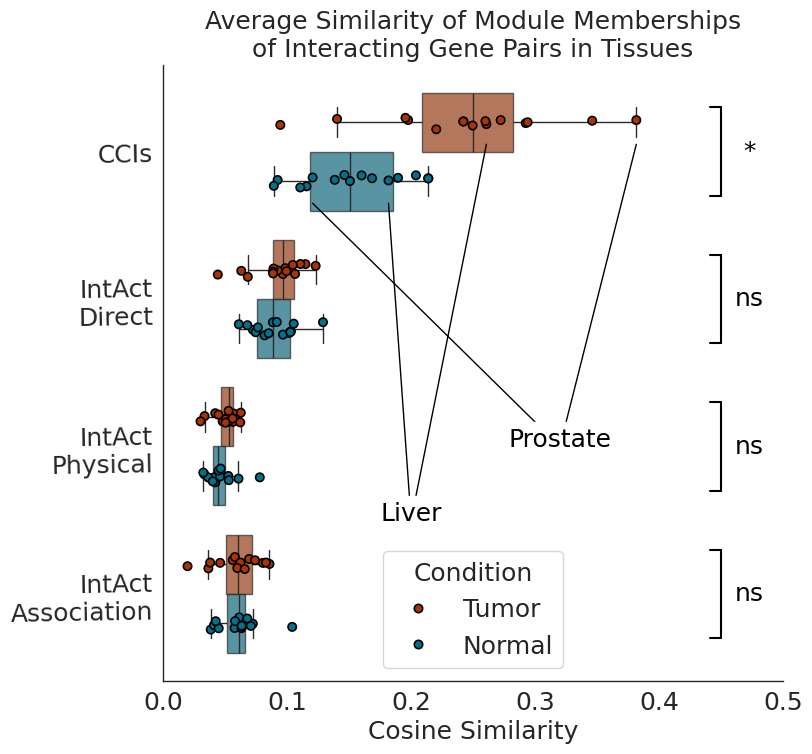

In [15]:
fs = 18  # Font size

# Ensure max_value is defined
order = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
labels = ['CCIs', 'IntAct\nDirect', 'IntAct\nPhysical', 'IntAct\nAssociation']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the horizontal boxplot (without outliers)
sns.boxplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    boxprops={"alpha": 0.7},
    showfliers=False,  # Hide outliers
    ax=ax,
    legend=False
)

# Overlay actual data points with jitter for better visibility
sns.stripplot(
    data=tissuemeans,
    y="Type",
    x="Value",
    hue="Condition",
    hue_order=["Tumor", "Normal"],
    palette={"Normal": ncolor, "Tumor": tcolor},
    order=order,
    dodge=True,
    jitter=True,
    size=6,
    edgecolor="black",
    linewidth=1.2,
    ax=ax
)

# ANNOTATE PROSTATE
prostate_points = tissuemeans.query('Tissue == "prostate" and Type == "ccc_lr_pairs"')
text_x = 0.32
text_y = 2

for _, row in prostate_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])  
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Prostate", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# ANNOTATE LIVER
liver_points = tissuemeans.query('Tissue == "liver" and Type == "ccc_lr_pairs"')
text_x = 0.2
text_y = 2.5

for _, row in liver_points.iterrows():
    x_value = row["Value"]
    y_value = order.index(row["Type"])
    offset = 0.35 if row['Condition'] == 'Normal' else -0.05

    ax.plot([x_value, text_x], [y_value + offset, text_y], "black", linestyle='-', linewidth=1, zorder=9)

ax.text(text_x, text_y, "Liver", fontsize=fs, color="black", ha='center',
        bbox=dict(facecolor="white", edgecolor="white", boxstyle=None), zorder=10)

# Ensure x-axis starts at 0
ax.set_xlim(0, 0.4)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower right')
legend.set_title("Condition", prop={'size': fs})


# Add vertical significance bars

pos = 0.45 # horizontal position of significance bar

for i, interaction_type in enumerate(order):
    # Check if the p-value for the current interaction type is significant
    y_position = i  # Corresponding y-axis position
    pval = pval_adj[interaction_type]

    # Draw significance bar
    ax.plot([pos, pos], [y_position - 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position - 0.3, y_position - 0.3], color='black', linestyle='-', zorder=9)
    ax.plot([0.98*pos, pos], [y_position + 0.3, y_position + 0.3], color='black', linestyle='-', zorder=9)
    
    label = 'ns' 
    label = '*' if pval  < 0.05 else label
    label = '**' if pval < 0.01 else label
    
    # Annotate with p-value
    ax.text(1.05*pos, y_position+0.08, f'{label}', fontsize=fs, color='black', ha='center', va='bottom', zorder=10)

# Rest of your plotting code...
# Ensure x-axis starts at 0
ax.set_xlim(0, 0.5)

# Set title
ax.set_title('Average Similarity of Module Memberships\nof Interacting Gene Pairs in Tissues', fontsize=fs)

# Set x-axis label
ax.set_xlabel('Cosine Similarity', fontsize=fs)

# Set y-axis labels
ax.set_yticks(range(len(order)))
ax.set_yticklabels(labels, fontsize=fs, rotation=1, ha='right')

# Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=fs)

# Adjust legend font size and location
legend = ax.legend(fontsize=fs, loc='lower center')
legend.set_title("Condition", prop={'size': fs})

# Remove ylabel
ax.set_ylabel('')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/rewiring_boxplot.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/rewiring_boxplot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [16]:
pval_adj

ccc_lr_pairs          0.010443
intact_association    1.000000
intact_direct         0.281969
intact_physical       0.281969
dtype: float64

In [17]:
interdf = pivoted_df.groupby(['Type', 'Condition', 'interaction'])['Value'].mean()
interdf = interdf.sort_values()[::-1]
interdf = interdf.to_frame().reset_index()
interdf.query('Type == "ccc_lr_pairs"')

,Type,Condition,interaction,Value
24,ccc_lr_pairs,Normal,AKR1D1_AR,0.995831
56,ccc_lr_pairs,Normal,APOA1_AMN,0.991600
58,ccc_lr_pairs,Normal,DBH_ADRA2B,0.991475
66,ccc_lr_pairs,Normal,DBH_ADRA1B,0.990875
99,ccc_lr_pairs,Normal,CYP11A1_NR1I2,0.987780
...,...,...,...,...
726904,ccc_lr_pairs,Normal,PTGES2_PTGER1,-0.947787
726986,ccc_lr_pairs,Tumor,PTGES3_PTGER1,-0.959807
727016,ccc_lr_pairs,Normal,APOA2_TYROBP,-0.965244
727037,ccc_lr_pairs,Normal,SULT1E1_PPARD,-0.968618


In [18]:
interdf

,Type,Condition,interaction,Value
0,intact_association,Normal,CALM1+CALM1,1.000000
1,intact_association,Tumor,CALM1+CALM1,1.000000
2,intact_direct,Normal,FGA+FGB,0.999874
3,intact_association,Normal,UGT2B7+UGT1A4,0.999561
4,intact_association,Normal,APOA1+TTR,0.999502
...,...,...,...,...
727131,intact_association,Normal,TARBP1+CREB3L3,-0.996637
727132,intact_association,Normal,MFSD12+SLC22A9,-0.996696
727133,intact_physical,Normal,DYNLT1+HSPB9,-0.997237
727134,intact_association,Normal,SERPINA3+MOGAT3,-0.997450


In [19]:
## fig_to_panels(fig, axes, '/home/lnemati/pathway_crosstalk/results/figures/rewiring/')

In [20]:
tissues = pivoted_df.Tissue.unique()
same_module = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/same_module_interactions_all_subtissues.csv')
same_module.loc[same_module.tissue == 'thyroid_gland', 'tissue'] = 'thyroid'
same_module = same_module.query('tissue in @tissues')
same_module = same_module.drop(columns='subtissue')

In [21]:
results = pd.DataFrame(columns=same_module.columns)

for (tissue, condition), df in same_module.groupby(['tissue', 'condition']):
    # Count occurrences in the same module
    mean_counts = df.set_index(['tissue', 'condition']).sum()
    # If more subtissues are present, check if the same module is in at least half of them
    mean_counts = mean_counts >= df.shape[0] / 2
    # Add back tissue and condition
    mean_counts['tissue'] = tissue
    mean_counts['condition'] = condition
    # Concatenate after resetting index
    mean_counts = mean_counts.to_frame().T.reset_index(drop=True)
    results = pd.concat([results, mean_counts], ignore_index=True)
    
results.head()


,tissue,condition,CDH1_ITGA2+ITGB1,CDH1_ITGAE+ITGB7,CDH1_KLRG1,CDH2_FCER2,CADM1_NECTIN3,CADM3_CADM1,CADM3_CADM4,CADM3_EPB41L1,...,LAMA2_ITGA1+ITGB1,LAMA3_ITGA1+ITGB1,LAMA4_ITGA1+ITGB1,LAMA5_ITGA1+ITGB1,LAMB1_ITGA1+ITGB1,LAMB2_ITGA1+ITGB1,LAMB3_ITGA1+ITGB1,LAMC1_ITGA1+ITGB1,LAMC2_ITGA1+ITGB1,LAMC3_ITGA1+ITGB1
0,adrenal_gland,normal,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,adrenal_gland,tumor,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,brain,normal,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,brain,tumor,True,False,False,False,True,True,True,True,...,False,False,True,False,True,False,False,True,False,False
4,breast,normal,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False


In [22]:
# Initialize an empty list to store results for each tissue
summary_data = []

# Loop through each tissue and calculate the required values
for tissue, df in results.set_index('condition').groupby('tissue'):
    df = df.drop(columns='tissue')  # Drop the redundant 'tissue' column
    tot = df.shape[1]
    n = df.loc['normal'].sum()
    t = df.loc['tumor'].sum()
    both = sum(df.sum() == 2)
    n_only = n - both
    t_only = t - both
    none = tot - n_only - t_only - both
    
    # Append a dictionary with the calculated values
    summary_data.append({
        'tissue': tissue,
        'tumor_only': t_only,
        'normal_only': n_only,
        'both': both,
        'none': none
    })

# Create a DataFrame from the list of dictionaries
summary_df = pd.DataFrame(summary_data)

# Display the resulting DataFrame
print(summary_df.head(3))

          tissue  tumor_only  normal_only  both  none
0  adrenal_gland         115          146    21  3709
1          brain         398          152    64  3377
2         breast         197          270    38  3486


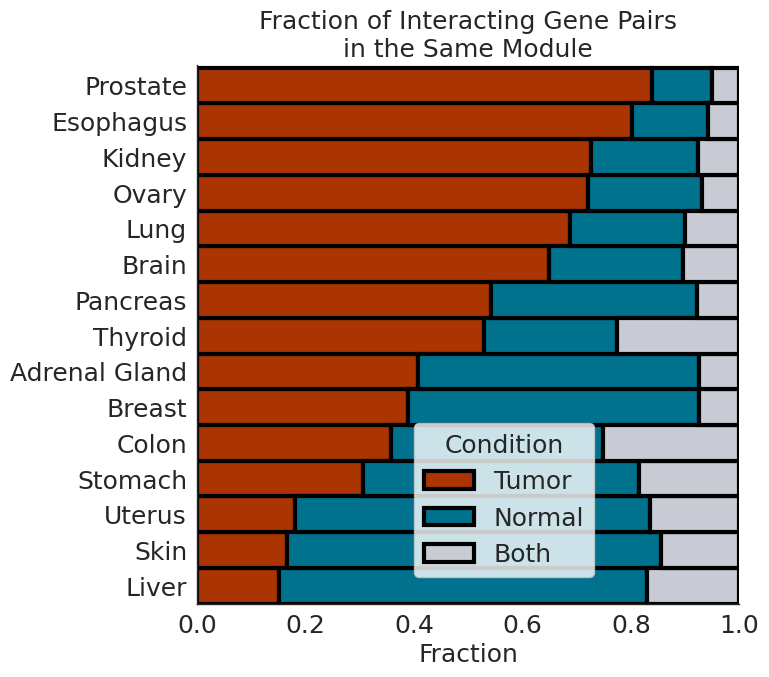

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fs=18

# Ensure tissue names are properly formatted
summary_df['tissue'] = summary_df['tissue'].str.replace('_', ' ').str.title()

# Exclude the 'none' category from calculations
summary_df['total'] = summary_df[['tumor_only', 'normal_only', 'both']].sum(axis=1)
for category in ['tumor_only', 'normal_only', 'both']:
    summary_df[category] = summary_df[category] / summary_df['total']

# Sort the DataFrame by the fraction of 'tumor_only'
summary_df = summary_df.sort_values(by='tumor_only', ascending=True)

# Plotting the horizontal stacked bar plot
categories = ['tumor_only', 'normal_only', 'both']  # Exclude 'none'
category_labels = ['Tumor', 'Normal', 'Both']  # Updated category names
colors = [tcolor, ncolor, lightgray]
tissues = summary_df['tissue']
data = summary_df[categories]

# Plot setup
fig, ax = plt.subplots(figsize=(7, 7))
y_positions = np.arange(len(tissues))

# Plot each category in the stacked bar
bottoms = np.zeros(len(tissues))
for idx, (category, label) in enumerate(zip(categories, category_labels)):
    ax.barh(
        y_positions,
        data[category],
        left=bottoms,
        label=label,
        height=1, # remove all space between bars
        color=colors[idx],  # Custom colors defined externally (tcolor, ncolor, lightgray)
        lw=3,
        edgecolor='k',
    )
    bottoms += data[category]

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(tissues)
ax.set_xlabel('Fraction', fontsize=fs)
ax.set_title('Fraction of Interacting Gene Pairs\nin the Same Module', fontsize=fs)
ax.legend(title='Condition', loc=(0.4, 0.05), title_fontsize=fs, fontsize=fs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove white space between bars
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(tissues) - 0.42)

ax.tick_params(axis='both', which='major', labelsize=fs)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.svg', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/rewiring/same_module_barplot.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


# Modules Enrichment

In [176]:
liver_n_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/normal/liver/module_enrichment.csv.gz')
modules = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/normal/liver/module_info.csv').set_index('module')
modules['rank'] = 'N' + modules['rank'].astype(str)
liver_n_enr['module'] = liver_n_enr.module.map(modules['rank'])
liver_n_enr = liver_n_enr[liver_n_enr['Adjusted P-value'] < 0.05]
liver_n_enr = liver_n_enr.sort_values(by='P-value', ascending=False)
liver_n_enr['Log Odds Ratio'] = np.log2(liver_n_enr['Odds Ratio'])

In [177]:
prostate_t_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/module_enrichment.csv.gz')
modules = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/module_info.csv').set_index('module')
modules['rank'] = 'T' + modules['rank'].astype(str)
prostate_t_enr['module'] = prostate_t_enr.module.map(modules['rank'])
prostate_t_enr = prostate_t_enr[prostate_t_enr['Adjusted P-value'] < 0.05]
prostate_t_enr = prostate_t_enr.sort_values(by='P-value', ascending=False)
prostate_t_enr['Log Odds Ratio'] = np.log2(prostate_t_enr['Odds Ratio'])

In [178]:
print('Liver Normal:')
print(liver_n_enr.query('module == "N1"').sort_values(by='P-value').Term.head(5))
print()

print('Prostate Tumor:')
print(prostate_t_enr.query('module == "T1"').sort_values(by='P-value').Term.head(5))

Liver Normal:
901             Gene expression (Transcription)
1692            RNA Polymerase II Transcription
903               Generic Transcription Pathway
1241                                 Metabolism
1580    Post-translational protein modification
Name: Term, dtype: object

Prostate Tumor:
2357            Gene expression (Transcription)
3146            RNA Polymerase II Transcription
2359              Generic Transcription Pathway
3034    Post-translational protein modification
2715                     Metabolism of proteins
Name: Term, dtype: object


In [179]:
nlist = liver_n_enr.query('module == "N1"').sort_values(by='P-value').iloc[0]['Genes'].split(';')
tlist = prostate_t_enr.query('module == "T1"').sort_values(by='P-value').iloc[0]['Genes'].split(';')

In [180]:
len(set(nlist).intersection(tlist)) / len(set(nlist).union(tlist))

0.6989409984871406

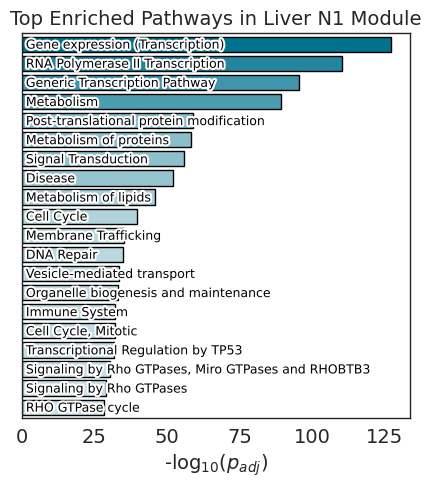

In [181]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 14
top_n = 20
x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
liver_n_enr['-log10(pvalue)'] = -np.log10(liver_n_enr["Adjusted P-value"])

# Sort and get top N entries
top_enriched = liver_n_enr.query('module == "N1"').sort_values('-log10(pvalue)', ascending=False).head(top_n)
top_enriched = top_enriched[::-1]  # Reverse for better barh order (smallest on bottom)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=top_enriched["-log10(pvalue)"].max())
colors1 = cmap1(norm1(top_enriched["-log10(pvalue)"].values))

bars1 = ax.barh(top_enriched["Term"], top_enriched["-log10(pvalue)"], 
                color=colors1, edgecolor='k', lw=1)

ax.set_title('Top Enriched Pathways in Liver N1 Module', fontsize=fs)
ax.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim = ax.get_xlim()[1]
for bar, label in zip(bars1, top_enriched["Term"]):
    text = ax.text(x_offset * xlim, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                   va='center', ha='left', fontsize=9, color='black', 
                   path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax.get_ylim()
ax.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

plt.show()


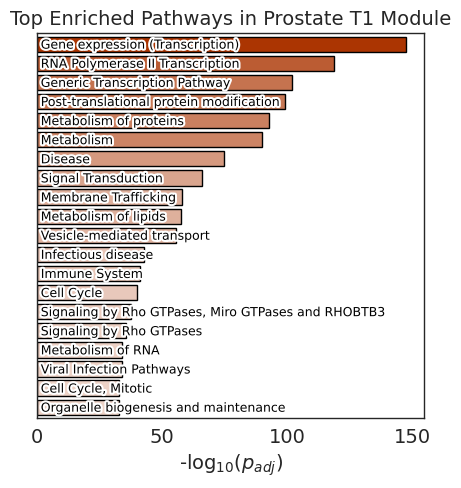

In [182]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 14
top_n = 20
x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
prostate_t_enr['-log10(pvalue)'] = -np.log10(prostate_t_enr["Adjusted P-value"])

# Sort and get top N entries from module T1
top_enriched = prostate_t_enr.query('module == "T1"').sort_values('-log10(pvalue)', ascending=False).head(top_n)
top_enriched = top_enriched[::-1]  # Reverse for better barh order

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm1 = mcolors.Normalize(vmin=0, vmax=top_enriched["-log10(pvalue)"].max())
colors1 = cmap1(norm1(top_enriched["-log10(pvalue)"].values))

bars1 = ax.barh(top_enriched["Term"], top_enriched["-log10(pvalue)"], 
                color=colors1, edgecolor='k', lw=1)

ax.set_title('Top Enriched Pathways in Prostate T1 Module', fontsize=fs)
ax.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim = ax.get_xlim()[1]
for bar, label in zip(bars1, top_enriched["Term"]):
    text = ax.text(x_offset * xlim, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                   va='center', ha='left', fontsize=9, color='black', 
                   path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax.get_ylim()
ax.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

plt.show()


In [184]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Get the 'Dark2' colormap
cmap = cm.get_cmap('tab10')

# Get the number of colors in the 'Dark2' ListedColormap
# Dark2 is a ListedColormap with 8 discrete colors
num_colors = cmap.N

# Convert each color to hex and print
for i in range(num_colors):
    rgba = cmap(i)  # Get RGBA tuple
    hex_color = mcolors.to_hex(rgba)
    print(f"Color {i}: {hex_color}")


Color 0: #1f77b4
Color 1: #ff7f0e
Color 2: #2ca02c
Color 3: #d62728
Color 4: #9467bd
Color 5: #8c564b
Color 6: #e377c2
Color 7: #7f7f7f
Color 8: #bcbd22
Color 9: #17becf


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 18 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'wspace': 0.05, 'width_ratios': [1, 1]})

fig.suptitle('Pathway Enrichment of CCIs in Liver Hepatocellular Carcinoma', fontsize=fs, y=0.94)

x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
n_enr['-log10(pvalue)'] = -np.log10(n_enr["Adjusted P-value"])
t_enr['-log10(pvalue)'] = -np.log10(t_enr["Adjusted P-value"])

# Create colormap for first plot
cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=n_enr["-log10(pvalue)"].max())
colors1 = cmap1(norm1(n_enr["-log10(pvalue)"].values))

bars1 = ax1.barh(n_enr["Term"], n_enr["-log10(pvalue)"], color=colors1, edgecolor='k', lw=1)
ax1.set_title('Normal Same Module, Tumor Different Modules', fontsize=fs)
ax1.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim1 = ax1.get_xlim()[1]
for bar, label in zip(bars1, n_enr["Term"]):
    text = ax1.text(x_offset * xlim1, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
ylim1, ylim2 = ax1.get_ylim()
ax1.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Create colormap for second plot
cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm2 = mcolors.Normalize(vmin=0, vmax=t_enr["-log10(pvalue)"].max())
colors2 = cmap2(norm2(t_enr["-log10(pvalue)"].values))

bars2 = ax2.barh(t_enr["Term"], t_enr["-log10(pvalue)"], color=colors2, edgecolor='k', lw=1)
ax2.set_title('Tumor Same Module, Normal Different Modules', fontsize=fs)
ax2.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim2 = ax2.get_xlim()[1]
for bar, label in zip(bars2, t_enr["Term"]):
    text = ax2.text(x_offset * xlim2, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax2.get_ylim()
ax2.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Set the same xlim for both axes based on the max of -log10(pvalue)
xlim1 = round(0.5 + n_enr['-log10(pvalue)'].max())
xlim2 = round(0.5 + t_enr['-log10(pvalue)'].max())
ax1.set_xlim(0, max(xlim1, xlim2))
ax2.set_xlim(0, max(xlim1, xlim2))

# Uncomment to save the figure
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.pdf', dpi=300, bbox_inches='tight')

plt.show()


# T Same / N Diff. & N Same / T Diff.

In [28]:
#bkg = '_with_background'
bkg = '_without_background'

# Liver
t_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/t_same_n_diff_enrichr'+bkg+'.csv')
t_enr = t_enr[t_enr['Adjusted P-value'] < 0.01]
#t_enr = t_enr.sort_values(by='Odds Ratio')
t_enr = t_enr.sort_values(by='P-value', ascending=False)
t_enr['Log Odds Ratio'] = np.log2(t_enr['Odds Ratio'])

n_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/n_same_t_diff_enrichr'+bkg+'.csv')
n_enr = n_enr[n_enr['Adjusted P-value'] < 0.01]
#n_enr = n_enr.sort_values(by='Odds Ratio')
n_enr = n_enr.sort_values(by='P-value', ascending=False)
n_enr['Log Odds Ratio'] = np.log2(n_enr['Odds Ratio'])


In [29]:
print(t_enr.shape)
print(n_enr.shape)

(80, 8)
(158, 8)


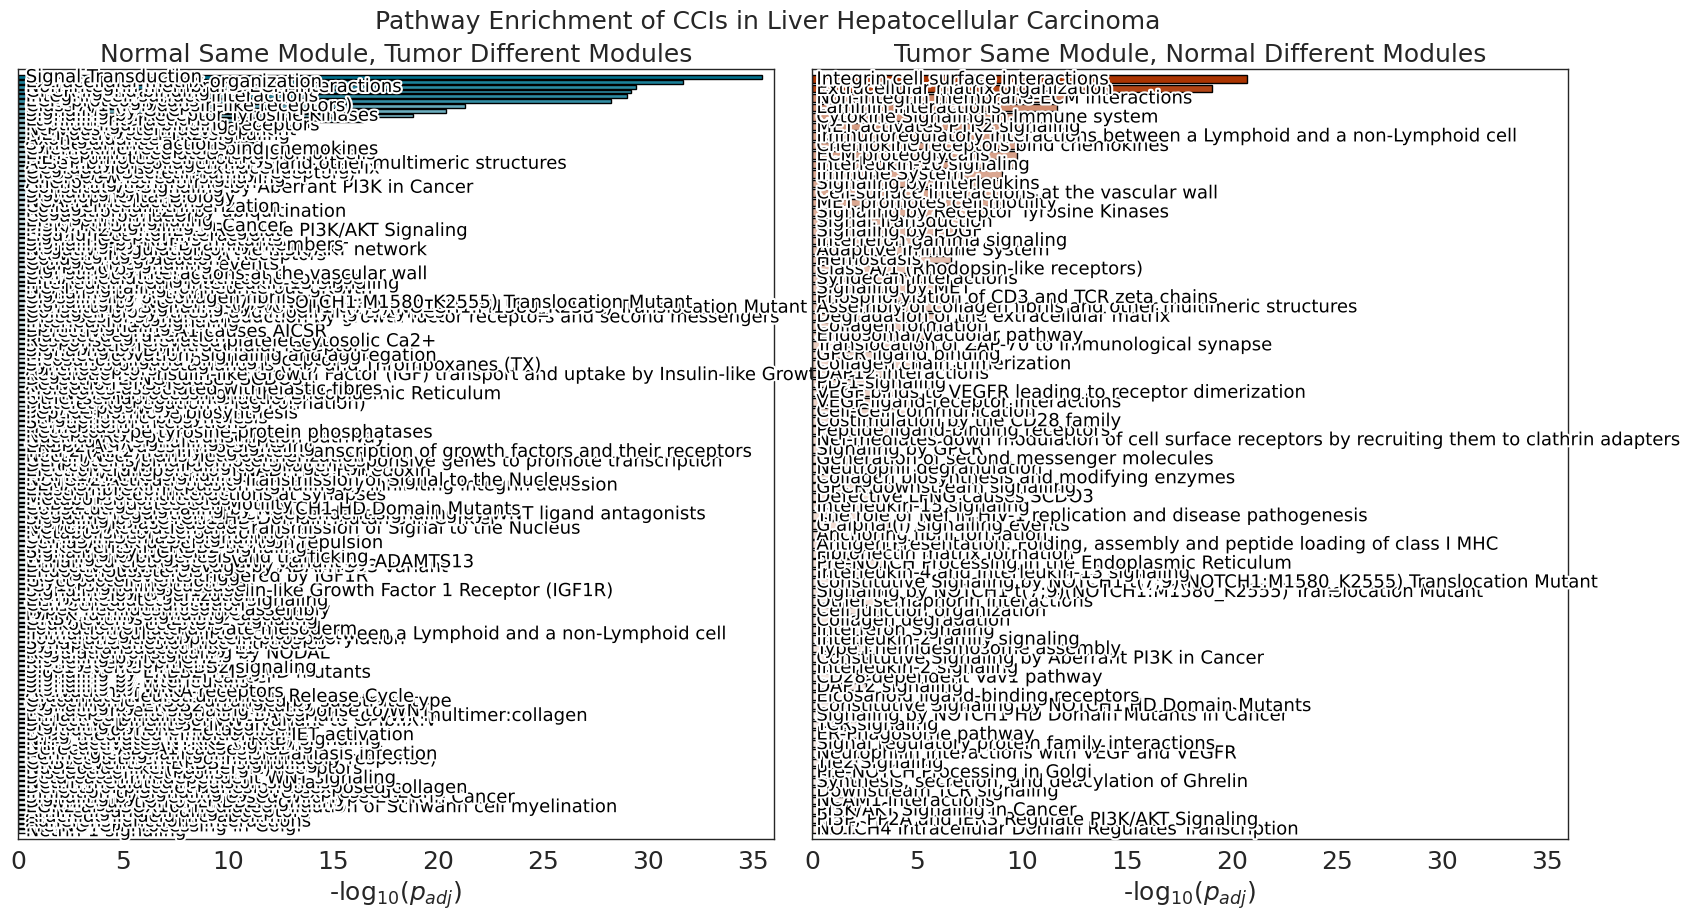

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 18 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'wspace': 0.05, 'width_ratios': [1, 1]})

fig.suptitle('Pathway Enrichment of CCIs in Liver Hepatocellular Carcinoma', fontsize=fs, y=0.94)

x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
n_enr['-log10(pvalue)'] = -np.log10(n_enr["Adjusted P-value"])
t_enr['-log10(pvalue)'] = -np.log10(t_enr["Adjusted P-value"])

# Create colormap for first plot
cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=n_enr["-log10(pvalue)"].max())
colors1 = cmap1(norm1(n_enr["-log10(pvalue)"].values))

bars1 = ax1.barh(n_enr["Term"], n_enr["-log10(pvalue)"], color=colors1, edgecolor='k', lw=1)
ax1.set_title('Normal Same Module, Tumor Different Modules', fontsize=fs)
ax1.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim1 = ax1.get_xlim()[1]
for bar, label in zip(bars1, n_enr["Term"]):
    text = ax1.text(x_offset * xlim1, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
ylim1, ylim2 = ax1.get_ylim()
ax1.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Create colormap for second plot
cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm2 = mcolors.Normalize(vmin=0, vmax=t_enr["-log10(pvalue)"].max())
colors2 = cmap2(norm2(t_enr["-log10(pvalue)"].values))

bars2 = ax2.barh(t_enr["Term"], t_enr["-log10(pvalue)"], color=colors2, edgecolor='k', lw=1)
ax2.set_title('Tumor Same Module, Normal Different Modules', fontsize=fs)
ax2.set_xlabel("-log$_{10}$($p_{adj}$)", fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim2 = ax2.get_xlim()[1]
for bar, label in zip(bars2, t_enr["Term"]):
    text = ax2.text(x_offset * xlim2, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax2.get_ylim()
ax2.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Set the same xlim for both axes based on the max of -log10(pvalue)
xlim1 = round(0.5 + n_enr['-log10(pvalue)'].max())
xlim2 = round(0.5 + t_enr['-log10(pvalue)'].max())
ax1.set_xlim(0, max(xlim1, xlim2))
ax2.set_xlim(0, max(xlim1, xlim2))

# Uncomment to save the figure
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/liver_enrichment.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [27]:
# liver tumor
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/t_same_n_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)
    
# https://string-db.org/cgi/network?taskId=bs3L2zgZ5OPz&sessionId=b5g0RKHpcGe5

140


CD86
PTGDR2
SULT1E1
CXCL10
SDC4
LAMC1
THBS3
ADRA2C
ANGPT2
COL7A1
GJA1
CCR2
IL7
ANGPT1
NECTIN3
CD47
PLXNA1
JAM3
CX3CR1
LAMB2
JAG1
NOTCH3
FLT4
ITGB2
PGF
SFRP4
WNT2B
THBS4
CCR1
KDR
COL3A1
HLA-DOB
PDGFA
CDH1
CCL8
TEK
NOTCH4
SV2A
CCL5
CYSLTR1
LAMB3
IL2RB
COL4A5
ANGPTL4
PLA2G7
IGF2R
PDGFRA
SGPP1
HLA-DPA1
HLA-DPB1
ITGB1
CD28
CXCL11
CCR5
PTPRC
NRP2
COL9A3
CD8A
PTGIS
PTGIR
GJA5
BCHE
CD22
CXCL9
SRD5A2
PPARD
CHRM3
VSIR
S1PR4
DBH
CCL4
AR
COL27A1
HLA-DMB
SPN
HLA-DRA
LCK
CCL3
ITGA5
SEMA5B
CD4
LTC4S
CD226
HLA-DQA2
TYROBP
NOTCH1
CD36
VEGFC
NAMPT
HLA-A
PLA2G2A
KLRK1
GGT5
SORT1
CX3CL1
IL2RG
SIRPB1
SULT1A1
CD44
HLA-F
SDC2
HPGD
ITGA6
PPARA
DLL1
ITGAL
CXCR3
CSF1
ACHE
PVR
LILRB1
PDGFRB
PDGFD
PTAFR
COL26A1
ITGA2
JAM2
LILRB2
PLAU
IL7R
PLAUR
ADGRG1
IL15RA
LAMA3
LAMA2
HLA-E
HLA-B
ICAM1
COL9A2
ITGAM
ITGAX
FN1
IGF2
SRD5A1
GRN
CSF1R
ITGA7
HLA-C
CD8B
IL15


In [28]:
# liver normal
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/n_same_t_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)
    
# https://string-db.org/cgi/network?taskId=bgMAaM1yDTVP&sessionId=b5g0RKHpcGe5

360


COL6A3
TGFBR1
C5AR2
SELE
CD248
CYP3A4
PLXNA1
SELL
JAM3
ADRB2
NGF
LTB4R
PTGER2
NLGN2
ITGB2
PTPRD
COL4A2
SLC29A3
FDXR
TNN
EPHB4
PLG
NTRK2
DHRS11
C5
CYP27B1
SGPP1
GDF11
GLS
LAMB1
SLC29A2
EFNB1
SELP
EFNA4
GRIA3
PILRA
ADA
HGF
CBR1
CHRM5
TNC
FRZB
KITLG
CXCL8
DBH
NR1I2
PNP
FZD3
ADGRG6
IGF1
SCARA5
S1PR3
PDGFB
CCL3
KIT
P2RY1
C5AR1
CD226
AKR1C3
PLXNA4
EPOR
LRP1
EPHB1
SORT1
CD44
OXT
F2
LAMC3
ACKR2
CXCL1
CLSTN2
NCAM1
PTGDS
ADORA2A
PDGFRB
CXCR2
PTAFR
HBEGF
FGFR2
ADRA1A
EPHA2
APLP2
APP
WNT3
EGFR
SHH
VDR
ITGB5
WNT5A
PLXNA3
LAMC1
THBS3
TENM1
PPARG
ITGAE
PODXL
CD47
DHCR7
DAG1
MET
BOC
LAMB2
ACVR1C
TNFSF14
POMC
WNT5B
WNT2B
VEGFA
HFE
EPHA1
CDH1
ICAM2
RSPO3
CCL5
UNC5C
EPHB3
ANGPTL4
LRP5
ACKR3
BMP8B
S1PR1
PTCH2
VWF
DHCR24
GDF7
COL9A3
LTBR
EFNA3
ANGPTL2
EFNB2
CXCL9
SFRP5
FTL
ADRA2B
ACVR2A
FLRT1
C3
NECTIN1
PTPRF
NTN4
SLIT2
MC1R
AR
EPHA4
ERBB2
PLXNB2
S1PR2
TLR4
CXCR1
IL6R
RORC
GPER1
FGF2
PTGES2
FZD4
MDK
LRRC4B
ADRA1B
FGF7
CLEC4M
CXCL6
SEMA3B
ITGA6
CD34
EFNA2
SEMA5A
CEL
IGF1R
CD96
AKR1D1
SLC1A2
LRP6
NRXN2

In [56]:
#bkg = '_with_background'
bkg = '_without_background'

# Prostate
t_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/t_same_n_diff_enrichr'+bkg+'.csv')
t_enr = t_enr[t_enr['Adjusted P-value'] < 0.01]
#t_enr = t_enr.sort_values(by='Odds Ratio')
t_enr = t_enr.sort_values(by='P-value', ascending=False)
t_enr['Log Odds Ratio'] = np.log2(t_enr['Odds Ratio'])

n_enr = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/n_same_t_diff_enrichr'+bkg+'.csv')
n_enr = n_enr[n_enr['Adjusted P-value'] < 0.01]
#n_enr = n_enr.sort_values(by='Odds Ratio')
n_enr = n_enr.sort_values(by='P-value', ascending=False)
n_enr['Log Odds Ratio'] = np.log2(n_enr['Odds Ratio'])


In [57]:
print(t_enr.shape)
print(n_enr.shape)

(203, 8)
(99, 8)


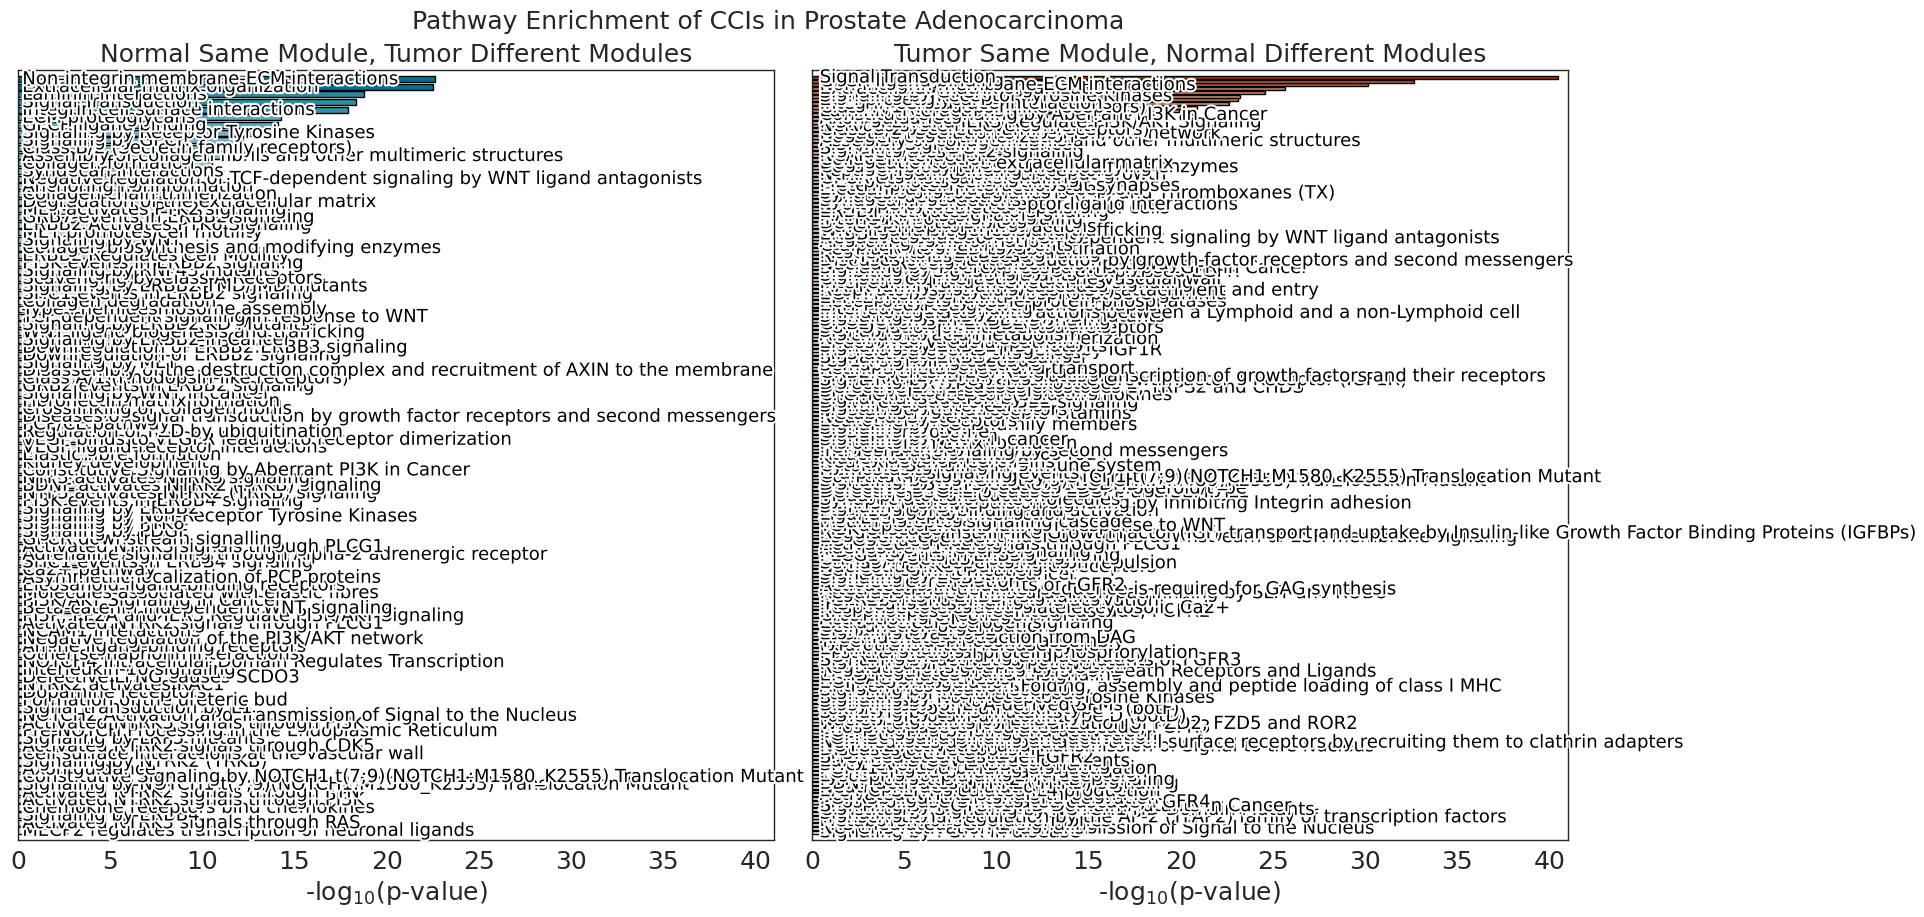

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patheffects as path_effects

fs = 18 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'wspace': 0.05, 'width_ratios': [1, 1]})

fig.suptitle('Pathway Enrichment of CCIs in Prostate Adenocarcinoma', fontsize=fs, y=0.94)

x_offset = 0.01
y_offset = -0.05

# Compute -log10(pvalue) for the data
n_enr['-log10(pvalue)'] = -np.log10(n_enr["P-value"])
t_enr['-log10(pvalue)'] = -np.log10(t_enr["P-value"])

# Create colormap for first plot
cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", ncolor])
norm1 = mcolors.Normalize(vmin=0, vmax=n_enr["-log10(pvalue)"].max())
colors1 = cmap1(norm1(n_enr["-log10(pvalue)"].values))

bars1 = ax1.barh(n_enr["Term"], n_enr["-log10(pvalue)"], color=colors1, edgecolor='k', lw=1)
ax1.set_title('Normal Same Module, Tumor Different Modules', fontsize=fs)
ax1.set_xlabel("-log$_{10}$(p-value)", fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim1 = ax1.get_xlim()[1]
for bar, label in zip(bars1, n_enr["Term"]):
    text = ax1.text(x_offset * xlim1, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax1.get_ylim()
ax1.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Create colormap for second plot
cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["white", tcolor])
norm2 = mcolors.Normalize(vmin=0, vmax=t_enr["-log10(pvalue)"].max())
colors2 = cmap2(norm2(t_enr["-log10(pvalue)"].values))

bars2 = ax2.barh(t_enr["Term"], t_enr["-log10(pvalue)"], color=colors2, edgecolor='k', lw=1)
ax2.set_title('Tumor Same Module, Normal Different Modules', fontsize=fs)
ax2.set_xlabel("-log$_{10}$(p-value)", fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_yticklabels([])  # Remove y-axis labels

# Add text labels inside bars with offset and outline
xlim2 = ax2.get_xlim()[1]
for bar, label in zip(bars2, t_enr["Term"]):
    text = ax2.text(x_offset * xlim2, bar.get_y() + bar.get_height()/2 + y_offset, label, 
                    va='center', ha='left', fontsize=13, color='black', 
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ylim1, ylim2 = ax2.get_ylim()
ax2.set_ylim(ylim1 + 0.04 * ylim2, 0.96 * ylim2)

# Set the same xlim for both axes based on the max of -log10(pvalue)
xlim1 = round(0.5 + n_enr['-log10(pvalue)'].max())
xlim2 = round(0.5 + t_enr['-log10(pvalue)'].max())
ax1.set_xlim(0, max(xlim1, xlim2))
ax2.set_xlim(0, max(xlim1, xlim2))

# Uncomment to save the figure
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/prostate_enrichment.png', dpi=300, bbox_inches='tight')
# plt.savefig('/home/lnemati/pathway_crosstalk/results/flow/enrichment/prostate_enrichment.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [324]:
# prostate tumor
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/t_same_n_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)

# https://string-db.org/cgi/network?taskId=b0KDywglKj5l&sessionId=b8gvcmqPNF76

472


LTB4R2
LRP5
PTGES2
C3
OSMR
FZD10
IGF1R
ADA
TNFRSF10C
ADGRL2
CD28
NPY1R
SLITRK5
GJC1
ANGPTL7
ITGA6
NECTIN2
SEMA5B
IGF2R
WNT5A
COL12A1
LILRB4
SRD5A1
DDC
LAMC3
EPHA2
BMPR1A
EPHA7
PODXL2
NOTCH2
CBR1
ROBO2
SFTPD
LAIR1
CD47
NAAA
CYP27B1
TGFA
GPR37
HSPG2
TNFRSF10A
CLSTN1
POSTN
FZD5
PTGER4
ALDH1A3
TAX1BP3
TNFRSF6B
FZD2
CCL3
ANXA1
HDC
GGT7
GDE1
ACVR1C
NLGN1
WNT9A
SLIT2
TNFRSF10D
PLXNA3
TLR4
COL2A1
SEMA5A
GFRA3
NTF4
EPHA5
HLA-A
S1PR3
PDGFD
NAPEPLD
COL9A1
PVR
GRIN2D
THY1
EPHB4
ENTPD1
HLA-DOA
NGFR
UBASH3B
STRA6
CXCR3
LAMB2
PPARA
ENPP1
LRRC4B
THBS3
FCGRT
PTGES3
ACVR2A
WNT3
WNT10B
PTCH1
LAMC1
NAMPT
LAMA3
ACVR2B
BTC
CD8A
FN1
DHCR24
EPHB3
CLSTN2
CXCL9
SGPP1
LAMA1
BMP2
GRIK1
COL26A1
ACVR1B
S1PR2
COL4A5
DAG1
ADA2
LRP1
SDC4
ADGRB1
NRG4
ADGRL3
THRB
CD8B
CEACAM6
ADGRL1
TNFRSF10B
SEMA3C
CDH1
LAMB3
SEMA4A
FGFR2
LGR6
NOTCH1
JAG2
SLC1A1
PDGFC
DAGLB
COL6A1
PSAP
COL4A2
GPR143
GAD1
VEGFA
LAMC2
SEMA4G
VLDLR
ACKR2
PTGDS
PTPRF
PTPRD
ESR1
CXCL11
THBS1
TENM3
DLL1
GRIK3
BMPR1B
HLA-B
CHRM3
TENM4
LTA4H
CYSLTR2
RORA

In [325]:
# prostate normal
genes = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/n_same_t_diff.csv')
genes = set(genes.interaction.apply(lambda x: re.split(r'[+_]', x)).sum())
print(len(genes))
print()
print()

for gene in genes:
    print(gene)

# https://string-db.org/cgi/network?taskId=bhOqxiYqDywQ&sessionId=b8gvcmqPNF76

114


CCRL2
LRP5
WNT3A
COL21A1
FTH1
COL8A2
NRG2
EFNB1
GRM2
ADRA2B
NTRK2
COL4A2
GAD1
LAMC2
SFRP4
UCN
HAVCR2
ITGA8
NOTCH4
DBH
SELP
VEGFD
KDR
ITGA6
ANGPT2
LILRB2
CCL19
PTGDS
COL12A1
PTPRF
ADGRE5
CCR5
LGALS9
WIF1
ITGA9
NOTCH2
ITGB4
FZD4
THBS1
FZD5
DLL1
PTGER4
PTPRC
TNFRSF6B
DKK1
GPR17
SFRP2
FZD2
NTRK3
CD22
DRD1
PTGDR2
NTN4
PRSS2
CRHR1
LRRTM1
WNT5B
FLT4
ADRA2C
FGFR4
LAMA5
ITGB1
COL4A1
TGFBR3
WNT11
PRSS1
VTN
ERBB4
COL24A1
SFRP5
FZD9
THY1
EPHB4
ITGA7
ITGA1
PTGS2
NRXN1
LPAR1
CD34
ADGRB3
TEK
CD69
ENPP1
NTF3
FZD1
SCARA5
F2RL3
KLRB1
WNT3
FTL
LAMA3
FN1
TNC
SORT1
TNFSF14
LAMA4
ITGA5
ERBB2
FZD3
FRZB
C1QL1
COL4A4
CD1D
NRG1
COL4A3
SFRP1
BDNF
SDC4
WNT16
CCL5
JAG1
DRD2
LRRC4C
ERBB3
